<a href="https://colab.research.google.com/github/moqimoqidea/A-Colab-Notebook/blob/master/gpu_demo_mandelbrot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 验证当前环境是否支持GPU

In [ ]:
!nvidia-smi

Sun Mar 10 07:09:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# 安装依赖

In [ ]:
!pip install -U numba numpy matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 MB 14.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.41.1
    Uninstalling llvmlite-0.41.1:
      Successfully uninstalled llvmlite-0.41.1
  Attempting uninstall: numba
    Found existing installation: numba 0.58.1
    Uninstalling numba-0.58.1:
      Successfully uninstalled numba-0.58.1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


# GPU vs CPU: Mandelbrot

starting gpu computation...
gpu computation time: 0.4687376022338867 seconds


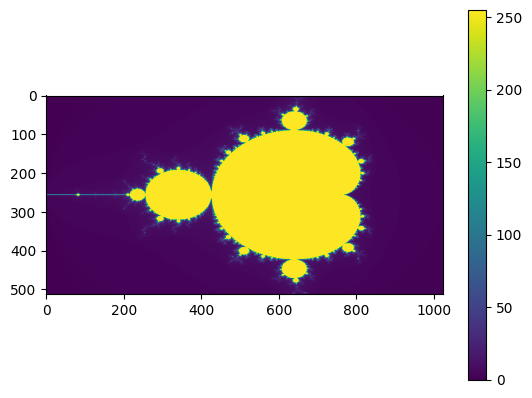

gpu total runtime: 0.7347464561462402 seconds




starting cpu computation...
cpu computation time: 0.896641731262207 seconds


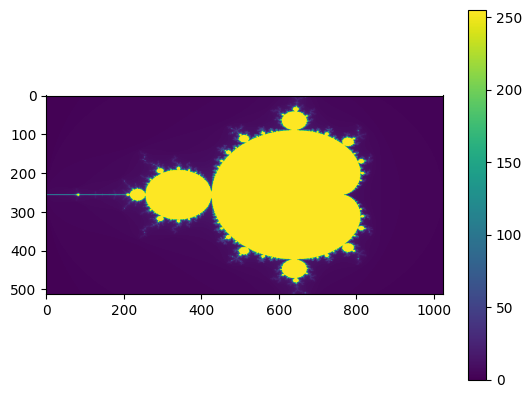

cpu total runtime: 1.157015085220337 seconds


In [ ]:
import time

import matplotlib.pyplot as plt
import numpy as np
from numba import cuda, jit


@cuda.jit
def gpu_mandelbrot_kernel(min_x, max_x, min_y, max_y, image, iters):
    height, width = image.shape
    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height

    # 线程ID和总线程数
    startX, startY = cuda.grid(2)
    gridX = cuda.gridDim.x * cuda.blockDim.x
    gridY = cuda.gridDim.y * cuda.blockDim.y

    # 每个线程计算多个点
    for x in range(startX, width, gridX):
        real = min_x + x * pixel_size_x
        for y in range(startY, height, gridY):
            imag = min_y + y * pixel_size_y
            c = complex(real, imag)
            z = 0.0j
            for i in range(iters):
                z = z * z + c
                if (z.real * z.real + z.imag * z.imag) >= 4:
                    image[y, x] = i
                    break
            else:
                image[y, x] = iters - 1


def gpu_compute_mandelbrot(min_x, max_x, min_y, max_y, image, iters):
    # 调整blockdim和griddim来匹配GPU特性和问题大小
    blockdim = (16, 16)
    griddim = (32, 32)

    d_image = cuda.to_device(image)
    start_time = time.time()
    gpu_mandelbrot_kernel[griddim, blockdim](min_x, max_x, min_y, max_y, d_image, iters)
    cuda.synchronize()
    end_time = time.time()
    print(f"gpu computation time: {end_time - start_time} seconds")

    d_image.copy_to_host(ary=image)


def gpu_main(min_x, max_x, min_y, max_y, width, height, iters):
    print("starting gpu computation...")
    image = np.zeros((height, width), dtype=np.uint8)
    gpu_compute_mandelbrot(min_x, max_x, min_y, max_y, image, iters)
    print_image(image)


@jit(nopython=True)
def cpu_mandelbrot(x, y, max_iters):
    """计算给定坐标的Mandelbrot集归属，并返回迭代次数。"""
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        if (z.real * z.real + z.imag * z.imag) >= 4:
            return i
        z = z * z + c
    return max_iters - 1


@jit(nopython=True)
def cpu_compute_mandelbrot(min_x, max_x, min_y, max_y, width, height, iters):
    """为整个图像生成Mandelbrot集。"""
    result = np.zeros((height, width), dtype=np.uint8)
    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height

    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = cpu_mandelbrot(real, imag, iters)
            result[y, x] = color
    return result


def cpu_main(min_x, max_x, min_y, max_y, width, height, iters):
    print("starting cpu computation...")
    start_time = time.time()
    image = cpu_compute_mandelbrot(min_x, max_x, min_y, max_y, width, height, iters)
    end_time = time.time()
    print(f"cpu computation time: {end_time - start_time} seconds")
    print_image(image)

def print_image(image):
    plt.imshow(image)
    plt.colorbar()
    plt.show()


if __name__ == '__main__':
    min_x, max_x = -2.0, 1.0
    min_y, max_y = -1.0, 1.0
    width, height = 1024, 512
    iters = 1024

    main_start_time = time.time()
    gpu_main(min_x, max_x, min_y, max_y, width, height, iters)
    main_end_time = time.time()
    print(f"gpu total runtime: {main_end_time - main_start_time} seconds")
    print('\n\n\n')

    main_start_time = time.time()
    cpu_main(min_x, max_x, min_y, max_y, width, height, iters)
    main_end_time = time.time()
    print(f"cpu total runtime: {main_end_time - main_start_time} seconds")


